In [228]:
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import LinearSVC
import matplotlib.pyplot as plt
from tqdm import tqdm, trange
from sklearn.metrics import confusion_matrix, rand_score, silhouette_score
from scipy.stats import poisson, norm
from sklearn.decomposition import PCA
import sys
import blip_analysis as ba
import exp_blip_models as em
import scipy.io as sio
import binary_recording as br
import pickle
from mpl_toolkits.axes_grid1 import make_axes_locatable
import daskify
from scipy.stats import skewnorm, mannwhitneyu, f_oneway, ttest_1samp
import scipy
from scipy.cluster.hierarchy import linkage, dendrogram
from sklearn.cluster import KMeans
import matplotlib
from matplotlib.gridspec import GridSpec
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
from scipy.stats import poisson
import importlib
from sklearn.preprocessing import StandardScaler
importlib.reload(ba)

<module 'blip_analysis' from '/home/camp/warnert/working/Recordings/binary_pulses/blip_analysis/blip_analysis.py'>

In [2]:
glyphs = ba.get_glyphs()

In [3]:
### Set up the data


In [3]:
_= ba.load_usrts()
good_indexes = ba.get_stable_resp_indexes()
print(len(good_indexes))

Found odour 1
Found odour 3
Found odour 5
130


In [4]:
units_usrt1 = pickle.Unpickler(open('230309_usrt_extended1.pkl', 'rb')).load()[good_indexes]
units_usrt2 = pickle.Unpickler(open('230309_usrt_extended2.pkl', 'rb')).load()[good_indexes]
units_usrt3 = pickle.Unpickler(open('230309_usrt_extended3.pkl', 'rb')).load()[good_indexes]

In [214]:
mean_usrt1 = np.array([[np.mean(i, axis=0) for i in j] for j in units_usrt1])
mean_usrt2 = np.array([[np.mean(i, axis=0) for i in j] for j in units_usrt2])
mean_usrt3 = np.array([[np.mean(i, axis=0) for i in j] for j in units_usrt3])

summed_usrt1 = np.array([[np.mean(i, axis=-1) for i in j] for j in units_usrt1])
summed_usrt2 = np.array([[np.mean(i, axis=-1) for i in j] for j in units_usrt2])
summed_usrt3 = np.array([[np.mean(i, axis=-1) for i in j] for j in units_usrt3])

summed_response1 = mean_usrt1[:, :, 50:100].sum(axis=-1)

In [92]:
mean_usrt1.shape

(130, 32, 112)

In [111]:
def z_scored_trials(unit_usrt, window_slice=slice(50, 100), shuffle=False):
    mean_usrt = np.array([[np.mean(i[:, window_slice], axis=-1) for i in j] for j in unit_usrt])
    stds = np.array([[np.std(i) for i in j] for j in mean_usrt])
    mean_stds = np.mean(stds, axis=-1)
    mean_mean_usrt = np.array([[np.mean(i) for i in j] for j in mean_usrt])
    print(mean_mean_usrt.shape)
    mean_mean_mean_usrt = mean_mean_usrt.mean(axis=-1)
    z_scored = (mean_mean_usrt - mean_mean_mean_usrt[:, np.newaxis])/mean_stds[:, np.newaxis]
    return z_scored

def z_scored_base(unit_usrt, window_slice=slice(50, 100), shuffle=False):
    mean_usrt = np.array([[np.mean(i[:, window_slice]) for i in j] for j in unit_usrt])
    #mean_mean_usrt = np.array([[np.mean(i) for i in j] for j in mean_usrt])
    scaler = StandardScaler()
    scaled = scaler.fit_transform(mean_usrt.T)
    return scaled.T
# z_scored1 = z_scored_trials(units_usrt1)
# z_scored2 = z_scored_trials(units_usrt2)
# z_scored3 = z_scored_trials(units_usrt3)
z_scored = z_scored_base(units_usrt1)

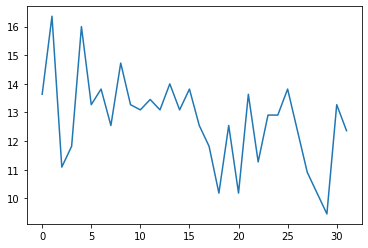

In [112]:
plt.plot(mean_usrt1[:, :, 50:100].mean(axis=-1)[0])


-7.563394355258879e-16


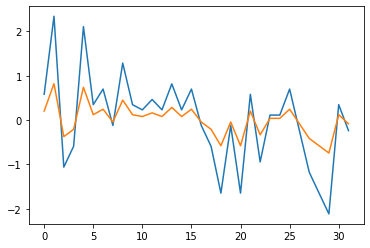

In [113]:
plt.plot(z_scored[0])
plt.plot(z_scored1[0])
print(np.mean(z_scored[0]))

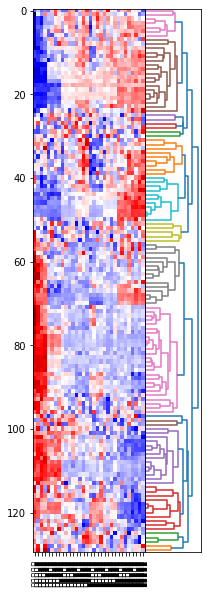

In [114]:
vmax = np.max(abs(z_scored))
fig = plt.figure(figsize=(3, 10))
gs = GridSpec(1, 3, wspace=0)
dend_ax = fig.add_subplot(gs[-1])
heatmap_ax = fig.add_subplot(gs[:-1])


link = linkage(z_scored, optimal_ordering=True, method='complete')
dend = dendrogram(link, ax=dend_ax, orientation='right')
heatmap_ax.imshow(z_scored[dend['leaves'][::-1]], vmax=vmax, vmin=-vmax, cmap='seismic', aspect='auto')
dend_ax.set_xticks([])
heatmap_ax.set_xticks(range(32))
heatmap_ax.set_xticklabels(glyphs, rotation=90);

In [58]:
print(dend['leaves'][:30])

[91, 81, 51, 50, 122, 45, 87, 48, 33, 29, 113, 123, 120, 125, 104, 99, 47, 40, 34, 35, 38, 1, 0, 8, 2, 9, 19, 13, 12, 17]


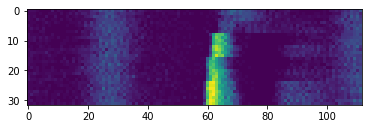

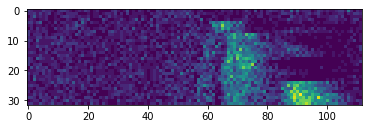

In [60]:
plt.imshow(mean_usrt1[81])
plt.figure()
plt.imshow(mean_usrt1[51])

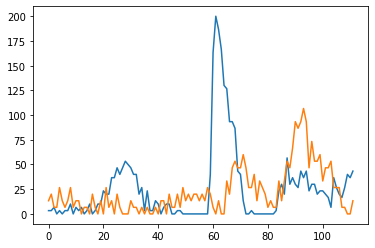

In [62]:
plt.plot(mean_usrt1[81, -1])
plt.plot(mean_usrt1[51, -1])

In [115]:
conc_trials = [0, 16, 24, 28, 30, 31]
onset_trials = [16, 8, 4, 2, 1, 0]
iti_trials = [24, 20, 18, 17]

0.44409511820798786


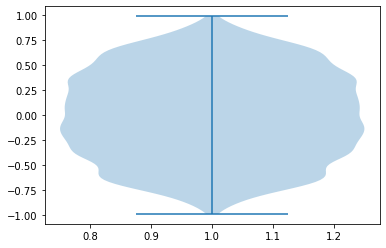

In [159]:
z_scored_shuf = z_scored1.copy()[:, conc_trials]
np.random.seed(1021)
corrs_shuf = []
for j in range(100):
    [np.random.shuffle(i) for i in z_scored_shuf];
    for i in range(130):
        corrs_shuf.append(np.corrcoef(z_scored_shuf[i], conc_vals)[0, 1])
plt.violinplot([corrs_shuf])
print(np.std(corrs_shuf))
corrs_shuf = np.array(corrs_shuf).reshape(130, 100)

([<matplotlib.axis.XTick at 0x7f0a4f4b4cc0>,
 <a list of 2 Text xticklabel objects>)

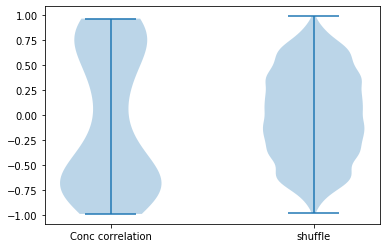

In [160]:
conc_vals = [0, 1, 2, 3, 4, 5]
corrs = []
for i in range(130):
    corrs.append(np.corrcoef(z_scored1[i, conc_trials], conc_vals)[0, 1])
plt.violinplot([corrs, corrs_shuf.flatten()])
plt.xticks([1, 2], labels=['Conc correlation', 'shuffle'])

{'bodies': [<matplotlib.collections.PolyCollection at 0x7f0a4ef9f9e8>,
 'cmaxes': <matplotlib.collections.LineCollection at 0x7f0a4ef9f7b8>,
 'cmins': <matplotlib.collections.LineCollection at 0x7f0a4ef9fa58>,
 'cbars': <matplotlib.collections.LineCollection at 0x7f0a4efae390>}

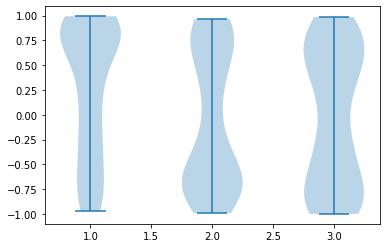

In [163]:
corrs_onset = []
corrs_iti = []
corrs_conc = []
for i in range(130):
    corrs_onset.append(np.corrcoef(z_scored[i, onset_trials[:-1]], conc_vals[1:])[0, 1])
    corrs_iti.append(np.corrcoef(z_scored[i, iti_trials], conc_vals[1:-1])[0, 1])
    corrs_conc.append(np.corrcoef(z_scored[i, conc_trials], conc_vals)[0, 1])
    
plt.violinplot([corrs_onset, corrs_conc, corrs_iti])

In [17]:
print(corrs_shuf.shape)

(130, 100)


In [133]:
print(np.std(corrs_shuf.flatten()))
print()

0.4434233821427561



In [162]:
print(len(np.where(corrs_conc > 2*np.std(corrs_shuf.flatten()))[0]))
print(len(np.where(corrs_conc < - 2*np.std(corrs_shuf.flatten()))[0]))
print(len(np.where(corrs_onset > 2*np.std(corrs_shuf.flatten()))[0]))
print(len(np.where(corrs_onset < - 2*np.std(corrs_shuf.flatten()))[0]))
print(len(np.where(corrs_iti > 2*np.std(corrs_shuf.flatten()))[0]))
print(len(np.where(corrs_iti < - 2*np.std(corrs_shuf.flatten()))[0]))

11
8
28
8
9
20


In [136]:
conc_tuned_cells = np.append(np.where(corrs_conc > 2*np.std(corrs_shuf.flatten()))[0], np.where(corrs_conc < - 2*np.std(corrs_shuf.flatten()))[0])
onset_tuned_cells = np.append(np.where(corrs_onset > 2*np.std(corrs_shuf.flatten()))[0], np.where(corrs_onset < - 2*np.std(corrs_shuf.flatten()))[0])
iti_tuned_cells = np.append(np.where(corrs_iti > 2*np.std(corrs_shuf.flatten()))[0], np.where(corrs_iti < - 2*np.std(corrs_shuf.flatten()))[0])

In [198]:
conc_count = 0
conc_cells = []
for i in onset_tuned_cells:
    if i in conc_tuned_cells:
        conc_count += 1
        conc_cells.append(i)
print(conc_count)
print(conc_cells)

5
[18, 21, 23, 60, 84]


[111  97  36  15  89  28  86  65  71  37 112  83   4  16   9   7  69   1
   0 108   5  39 129  46 118  32 116  77 106  56  14 127  67 128  12   6
 114 117  66   3  38  19  35  20  82 119  75  53  72 103   8  30  24  25
  10  22  48  95 115 105  63  99  13  76 104  42  78  85  87 126  88 101
  80  79  73 102 107  27   2  40  93  61  96  57  94  90  54 100  45  92
  34  74  33 121 120  26  47  98  51  81  29  91  64  49 113  11  41 125
  70  23  43  17  44 109  31  18  21  60  59 124  55 110  52  84  62  50
 123  58 122  68]


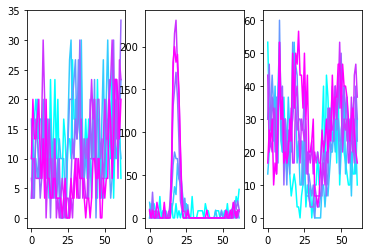

In [189]:
print(np.argsort(np.abs(corrs_conc)))
fig = plt.figure()
gs = GridSpec(1, 3)
axs = [fig.add_subplot(gs[i]) for i in range(3)]
for index, i in enumerate(conc_trials):
    axs[0].plot(mean_usrt1[68, i, 50:], color=matplotlib.cm.cool(index/5))
    axs[1].plot(mean_usrt1[122, i, 50:], color=matplotlib.cm.cool(index/5))
    axs[2].plot(mean_usrt1[58, i, 50:], color=matplotlib.cm.cool(index/5))

In [197]:
print(np.corrcoef(mean_usrt1[68, conc_trials[-1]], mean_usrt1[122, conc_trials[-1]]))

[[ 1.         -0.15785579]
 [-0.15785579  1.        ]]


[ 55  70   7   2  13 128  52   4 129  61  59  20  46   9  98  43   8 120
  77   0   6 109  38  22   1  81  62  44  66 127  83 110  68  17 124  19
 125  71 113  54 123  78  42  16  64  15 121  86 107  67  30   5  28   3
  41  32  53  31  45  14 116  25  33  24  74  92 108 126  49  91  29  39
  12  94  73 122  93  26 112 118  58 119  72  50 102  82 117  79  89  35
 115  37  90  87  60  47  34  21  96  36 101  65  57 100  97  11  76 104
  56  99  18  80  10  23 114  95 105  75  85  84  88  51  40 103  69  48
 106  27 111  63]
0.9934036770178827


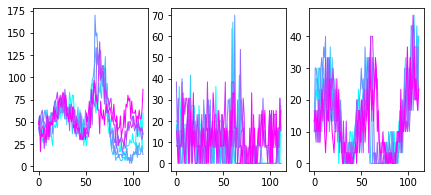

In [196]:
print(np.argsort(np.abs(corrs_onset)))
print(np.max(corrs_onset))
fig = plt.figure(figsize=(7, 3))
gs = GridSpec(1, 3)
axs = [fig.add_subplot(gs[i]) for i in range(3)]
for index, i in enumerate(onset_trials):
    axs[0].plot(mean_usrt1[63, i,], color=matplotlib.cm.cool(index/5), linewidth=1)
    axs[1].plot(mean_usrt1[111, i,:], color=matplotlib.cm.cool(index/5), linewidth=1)
    axs[2].plot(mean_usrt1[27, i, :], color=matplotlib.cm.cool(index/5), linewidth=1)

[118  80  19  61  38   6  76   1 127 110   8  55 128  13 103 124  82  21
  93  94   5   0  20  64  75  57  84  58  12  59   2  16 129  18  10  17
 117 125 100  79  22  92  45  26  14  27  32  89   4  54  46  11  28 114
  62  70  56 115 126  25  71  77  96 108  78   3 116  66  69 123 109 106
 105 111  49 112  40  83 121  42  74  95  72  23  35  47   7  68  73  15
 113 120  97  88  85 107  51  86  37  39  87  36  30 101  98  50  52  81
  63  48  91  44  31  34  43  33  67 119 102  65  53   9  41 122  90  29
  99  24 104  60]


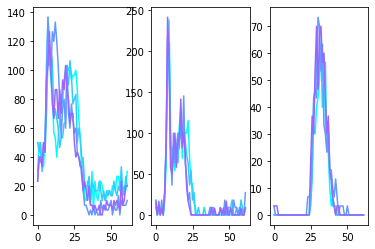

In [185]:
print(np.argsort(np.abs(corrs_iti)))
fig = plt.figure()
gs = GridSpec(1, 3)
axs = [fig.add_subplot(gs[i]) for i in range(3)]
for index, i in enumerate(iti_trials):
    axs[0].plot(mean_usrt1[60, i, 50:], color=matplotlib.cm.cool(index/5))
    axs[1].plot(mean_usrt1[104, i, 50:], color=matplotlib.cm.cool(index/5))
    axs[2].plot(mean_usrt1[24, i, 50:], color=matplotlib.cm.cool(index/5))
    

In [235]:
conc_corr_indexes = np.argsort(np.abs(corrs_conc))
onset_corr_indexes = np.argsort(np.abs(corrs_onset))
iti_corr_indexes = np.argsort(np.abs(corrs_iti))

In [110]:
print(ttest_1samp([1, 1], 2))

Ttest_1sampResult(statistic=-inf, pvalue=0.0)


In [116]:
print(np.array(corrs_shuf).reshape(130, 100))

(130, 100)


0.44380527541240816


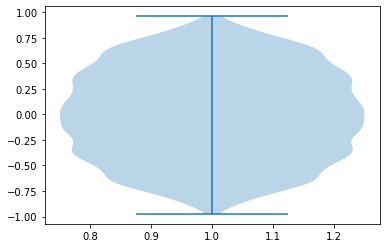

In [157]:
z_scored_shuf = z_scored1.copy()[:, conc_trials]
corrs_shuf = []
for j in range(100):
    [np.random.shuffle(i) for i in z_scored_shuf];
    for i in range(130):
        corrs_shuf.append(np.corrcoef(z_scored_shuf[i], conc_vals)[0, 1])
plt.violinplot([corrs_shuf])
print(np.std(corrs_shuf))
corrs_shuf = np.array(corrs_shuf).reshape(130, 100)

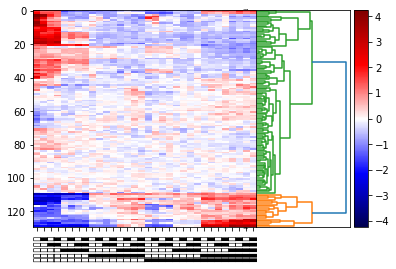

In [230]:
def z_scored_heatmap(fig, glob_gs, z_scored):
    gs = glob_gs.subgridspec(1, 3, wspace=0)
    dend_ax = fig.add_subplot(gs[-1])
    heatmap_ax = fig.add_subplot(gs[:-1])


    link = linkage(z_scored, optimal_ordering=True, method='complete')
    dend = dendrogram(link, ax=dend_ax, orientation='right')
    im = heatmap_ax.imshow(z_scored[dend['leaves'][::-1]], vmax=vmax, vmin=-vmax, cmap='seismic', aspect='auto')
    dend_ax.set_xticks([])
    heatmap_ax.set_xticks(range(32))
    heatmap_ax.set_xticklabels(glyphs, rotation=90);
    divider = make_axes_locatable(dend_ax)
    cax = divider.append_axes("right", size="15%", pad=0.05)
    plt.colorbar(cax=cax, mappable=im)
fig = plt.figure()
gs = GridSpec(1, 1)
z_scored_heatmap(fig, gs[0], z_scored1)

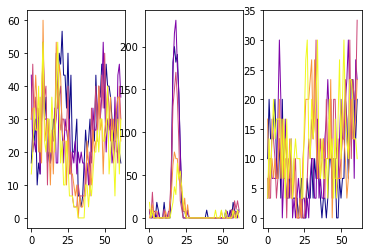

In [241]:
def plot_example_units(fig, glob_gs, mean_usrt, trial_indexes, unit_indexes, time_slice=slice(50, 112)):
    gs = glob_gs.subgridspec(1, 3)
    axs = [fig.add_subplot(gs[i]) for i in range(3)]
    for index_u, unit_index in enumerate(unit_indexes):
        for index_i, i in enumerate(trial_indexes):
            axs[index_u].plot(mean_usrt[unit_index, i, time_slice], color=matplotlib.cm.plasma(index_i/4), linewidth=1)
fig = plt.figure()
gs = GridSpec(1, 1)
plot_example_units(fig, gs[0], mean_usrt1, conc_trials, conc_corr_indexes[-3:])


In [ ]:
plt.imshow(mean_usrt1)

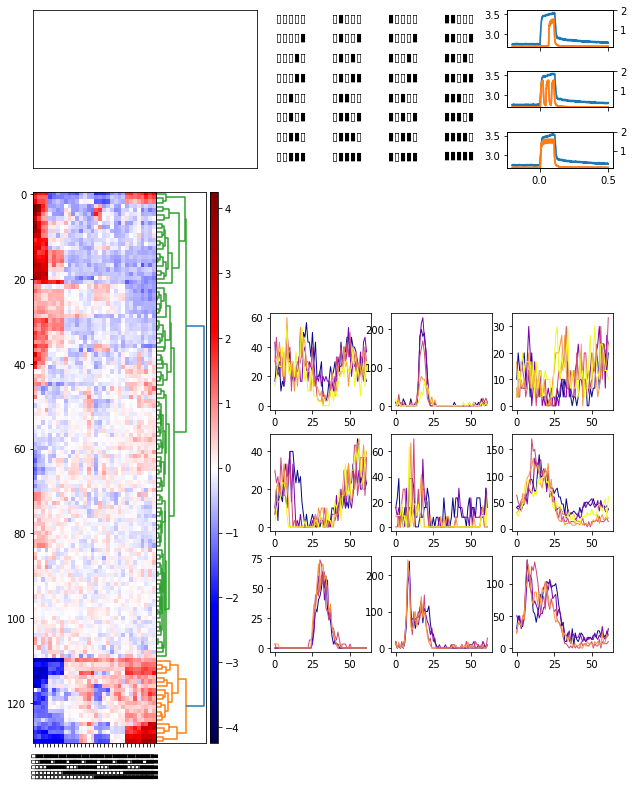

In [250]:
fig = plt.figure(figsize=(8.3, 11.7))
gs = matplotlib.gridspec.GridSpec(25, 15,wspace=.5, hspace=4, left=0.0, right=0.97, bottom=0.1, top=0.97)

mouse_ax = fig.add_subplot(gs[:6, :6])
mouse_ax.set_xticks([])
mouse_ax.set_yticks([])
blip_ax = fig.add_subplot(gs[:6, 6:12])
for i in range(32):
    blip_ax.text(int(i/8)+0.1, 8-i%8-0.5, glyphs[i], fontsize=11)
blip_ax.set_xlim(0, 4)
blip_ax.set_ylim(0, 8)
blip_ax.axis('off')

odour_ax1 = fig.add_subplot(gs[:2, 12:15])
odour_ax2 = fig.add_subplot(gs[2:4, 12:15], sharex=odour_ax1, sharey=odour_ax1)
odour_ax3 = fig.add_subplot(gs[4:6, 12:15], sharex=odour_ax1, sharey=odour_ax1)
plt.setp(odour_ax1.get_xticklabels(), visible=False)
plt.setp(odour_ax2.get_xticklabels(), visible=False)
odour_ax1 = plot_pid_and_flow(3, odour_ax1)
odour_ax2 = plot_pid_and_flow(21, odour_ax2)
odour_ax3 = plot_pid_and_flow(31, odour_ax3)
z_scored_heatmap(fig, gs[6:, :5], z_scored1)
plot_example_units(fig, gs[10:14, 6:], mean_usrt1, conc_trials, conc_corr_indexes[-3:])
plot_example_units(fig, gs[14:18, 6:], mean_usrt1, onset_trials, onset_corr_indexes[-3:])
plot_example_units(fig, gs[18:22, 6:], mean_usrt1, iti_trials, iti_corr_indexes[-3:])

{'bodies': [<matplotlib.collections.PolyCollection at 0x7f0bba8d4160>],
 'cmaxes': <matplotlib.collections.LineCollection at 0x7f0bba8c6e80>,
 'cmins': <matplotlib.collections.LineCollection at 0x7f0bba8d4400>,
 'cbars': <matplotlib.collections.LineCollection at 0x7f0bba8d41d0>}

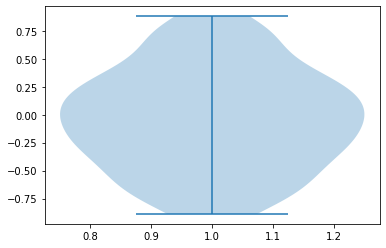

In [62]:
corrs_shuf = []
for i in range(130):
    corrs_shuf.append(np.corrcoef(z_scored_shuf[i, conc_trials], conc_vals)[0, 1])
plt.violinplot([corrs_shuf])

In [63]:
print(np.std(corrs_shuf))

0.45076711419643317


In [11]:
z_scored_summed_response1 = (summed_response1 - np.min(summed_response1, axis=-1)[:, np.newaxis])/(np.max(summed_response1, axis=-1)[:, np.newaxis] - np.min(summed_response1, axis=-1)[:, np.newaxis])


Text(17, -2, '▮▯▯▯▯')

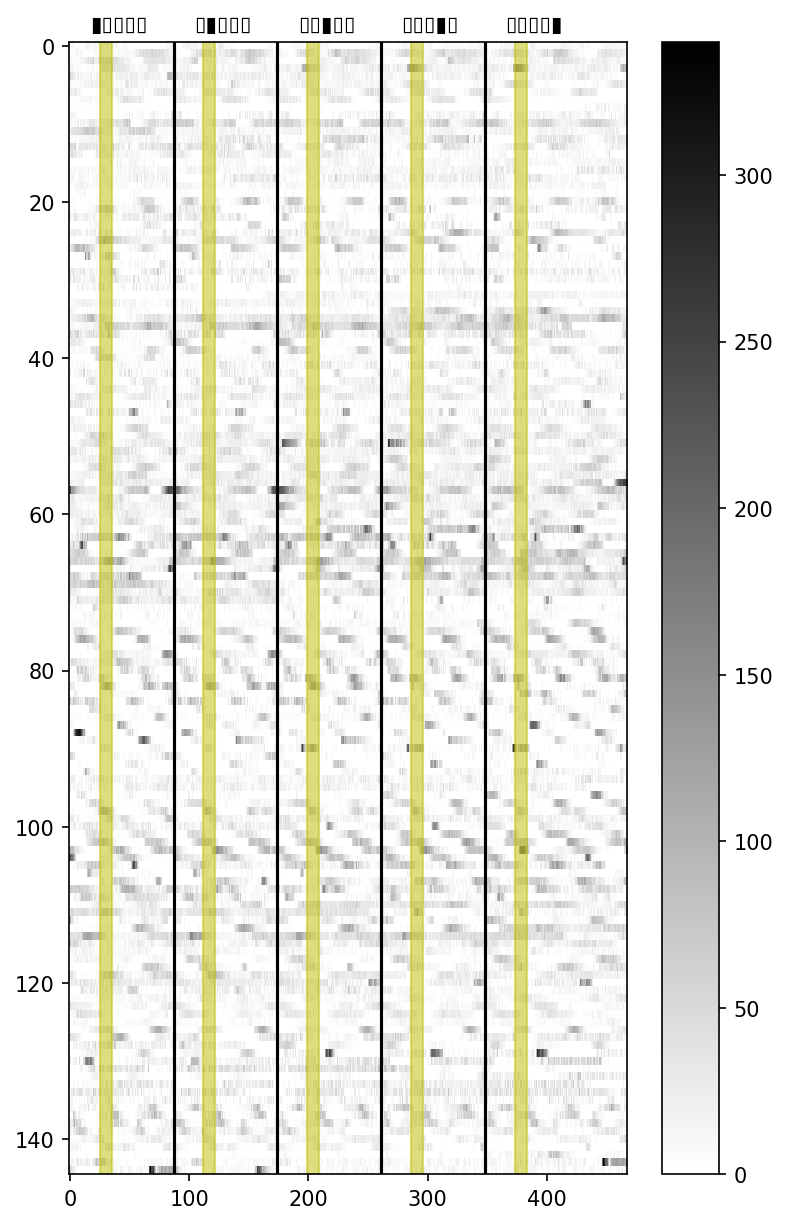

In [199]:
plt.figure(figsize=(6, 10), dpi=150)
sorted_args = np.argsort(np.argmax(mean_usrt1[:, onset_trials[-1]], axis=-1))

plt.imshow(mean_usrt1[sorted_args][:, onset_trials, 25:].reshape(145, -1), cmap='binary', aspect='auto')
plt.axvspan(25, 35, color='y', alpha=0.5)
for i in range(1, 5):
    plt.axvline(87*i, color='k')
    plt.axvspan(25+87*i, 35+87*i, color='y', alpha=0.5)
    plt.text(17+87*i, -2, glyphs[onset_trials[i]])
plt.colorbar()
plt.text(17, -2, glyphs[onset_trials[0]])

In [200]:
### Sort 
sorted_args = np.argsort(np.argmax(mean_usrt1[:, -1,], axis=-1))
print(sorted_args)

[106 118 114 119 108 121 126  15  76 109 112 128  97 116  19  92 101  79
 115  10   5  77  68  82  85  95  96  88  57  94  93  31  83  56  11  99
  52  75  69 103 105  72 104  53  40 107 117 111  35  46  66  48  62  54
   8 120 125  81  34  39 129  91  37  36 113   9   6  50  45 102 110  78
   4  87   0  42  49   7  26 122 123  86  38  98 127  17 124  70  67  58
  59  29  33  18  30  71  89  55  60  63  22  64  65  16  21  25  24  23
  47  14  13  12  73  51  20   2  44  28   1   3  41  32  90  43  27  84
 100  80  61  74]


In [202]:
select_trials = [31, 30, 28, 24, 16, 8, 4, 2, 1, 0]
conc_trials = [31, 30, 28, 24, 16]
onset_trials = [1, 2, 4, 8, 16]

[print(bin(i)) for i in select_trials]

0b11111
0b11110
0b11100
0b11000
0b10000
0b1000
0b100
0b10
0b1
0b0


[None, None, None, None, None, None, None, None, None, None]

In [ ]:
### Generate the plots for the stimuli
plots_conc = [br.binary_plotter(i) for i in conc_trials]
plots_onset = [br.binary_plotter(i) for i in onset_trials]
plots_all = [br.binary_plotter(i) for i in select_trials]

In [204]:
### Getting the PID and flow recording
odour_path = "/home/camp/warnert/working/Recordings/Set up recordings/200615 - Binary pulse calibration/"


EB_trials = open(odour_path + '2020-06-15trial_name_flowmeter_EB_2.txt', 'r').readlines()
trial_order = []
for i in EB_trials:
    if ':' not in i:
        trial_order.append(i.split('_')[1][:-1])
EB_flows = sio.loadmat(odour_path+'Flowmeter_EB_pulses_3.mat')
print(EB_flows.keys())
trig = EB_flows['Flowmeter_EB_pulses_3_Ch8'][-1][-1][-1]
EB_flowmeter = EB_flows['Flowmeter_EB_pulses_3_Ch7'][-1][-1][-1]
print(EB_flows.keys())

EB_PIDs = sio.loadmat(odour_path+'PID_all_pulses_PID.mat')

PID = EB_PIDs['PID_all_pulses_PID_Ch6'][-1][-1][-1]
PID_trig = EB_PIDs['PID_all_pulses_PID_Ch8'][-1][-1][-1]

PID_trials = open(odour_path+'2020-06-15trial_name.txt', 'r').readlines()
PID_order = []
for i in PID_trials:
    if ':' not in i:
        PID_order.append(i.split('_')[1][:-1])
        

IA_flows = sio.loadmat(odour_path+'Flowmeter_IA_pulses.mat')
trig_IA = IA_flows['Flowmeter_IA_pulses_Ch8'][-1][-1][-1]
flowmeter_IA = IA_flows['Flowmeter_IA_pulses_Ch7'][-1][-1][-1]

IA_trials = open(odour_path+'2020-06-15trial_name_flowmeter_IA.txt')
IA_order = []

for i in IA_trials:
    if ':' not in i:
        IA_order.append(i.split('_')[1][:-1])
        
prev_start = 0
EB_flow_starts = []
for index, i in enumerate(trig):
    if i > 1 and index - prev_start > 10000:
        EB_flow_starts.append(index)
        prev_start = index

        
PID_starts = []
prev_start = 0
for index, i in enumerate(PID_trig):
    if i > .5 and index - prev_start > 10000:
        PID_starts.append(index)
        prev_start = index
print(len(PID_starts)/32)

IA_starts = []
prev_start = 0
for index, i in enumerate(trig_IA):
    if i > 1 and index - prev_start > 10000:
        IA_starts.append(index)
        prev_start = index
        
trial_order = np.array(trial_order)
PID_order = np.array(PID_order)
EB_flow_starts = np.array(EB_flow_starts)
PID_starts = np.array(PID_starts)
IA_starts = np.array(IA_starts)
IA_order = np.array(IA_order)
fs = 10000
pre_window=0.5
post_window=0.62
#trial_order.astype(np.int)
all_trial_flows = []
all_trials_PID = []
all_trials_IA = []
for i in range(32):
    trial_starts = EB_flow_starts[(trial_order == str(i))]
    trial_flows = [EB_flowmeter[int(j-fs*pre_window):int(j+fs*post_window)] for j in trial_starts]
    all_trial_flows.append(trial_flows)
    PID_trials = PID_starts[(PID_order == str(i))]
    trial_PIDs = [PID[int(j-fs*pre_window):int(j+fs*post_window)] for j in PID_trials]
    all_trials_PID.append(trial_PIDs)
    
    trials_IA = IA_starts[(IA_order == str(i))]
    trial_IAs = [flowmeter_IA[int(j - fs*pre_window):int(j+fs*post_window)] for j in trials_IA]
    all_trials_IA.append(trial_IAs)
mean_trial_flows = np.mean(all_trial_flows, axis=1)
mean_trial_PIDs = np.mean(all_trials_PID, axis=1)
mean_trial_IA = np.mean(all_trials_IA, axis=1)

dict_keys(['__header__', '__version__', '__globals__', 'Flowmeter_EB_pulses_3_Ch1', 'Flowmeter_EB_pulses_3_Ch2', 'Flowmeter_EB_pulses_3_Ch3', 'Flowmeter_EB_pulses_3_Ch4', 'Flowmeter_EB_pulses_3_Ch5', 'Flowmeter_EB_pulses_3_Ch6', 'Flowmeter_EB_pulses_3_Ch7', 'Flowmeter_EB_pulses_3_Ch8', 'Flowmeter_EB_pulses_3_Ch31'])
dict_keys(['__header__', '__version__', '__globals__', 'Flowmeter_EB_pulses_3_Ch1', 'Flowmeter_EB_pulses_3_Ch2', 'Flowmeter_EB_pulses_3_Ch3', 'Flowmeter_EB_pulses_3_Ch4', 'Flowmeter_EB_pulses_3_Ch5', 'Flowmeter_EB_pulses_3_Ch6', 'Flowmeter_EB_pulses_3_Ch7', 'Flowmeter_EB_pulses_3_Ch8', 'Flowmeter_EB_pulses_3_Ch31'])
5.0


In [205]:
mats = sio.loadmat('/home/camp/warnert/working/Recordings/Set up recordings/200618 - Binary pulse calibration/200618_EB_IA_5_reps_altered_duties.mat')
print(mats.keys())
trigs = mats['V200618_EB_IA_5_reps_altered_duties_Ch8'][-1][-1][-1]
flows = mats['V200618_EB_IA_5_reps_altered_duties_Ch7'][-1][-1][-1]

prev_start = 0 
flow_starts = []
for index, i in enumerate(trigs):
    if i > 1 and index - prev_start > 10000:
        flow_starts.append(index)
        prev_start = index
        
all_flows = []
for i in range(64):
    reps = flow_starts[i::64]
    flow_reps = [flows[j-2000:j+5000] for j in reps]
    all_flows.append(flow_reps)

dict_keys(['__header__', '__version__', '__globals__', 'V200618_EB_IA_5_reps_altered_duties_Ch1', 'V200618_EB_IA_5_reps_altered_duties_Ch2', 'V200618_EB_IA_5_reps_altered_duties_Ch3', 'V200618_EB_IA_5_reps_altered_duties_Ch4', 'V200618_EB_IA_5_reps_altered_duties_Ch5', 'V200618_EB_IA_5_reps_altered_duties_Ch6', 'V200618_EB_IA_5_reps_altered_duties_Ch7', 'V200618_EB_IA_5_reps_altered_duties_Ch8', 'V200618_EB_IA_5_reps_altered_duties_Ch31'])


Text(0.5, 1.0, 'EB_10/1010')

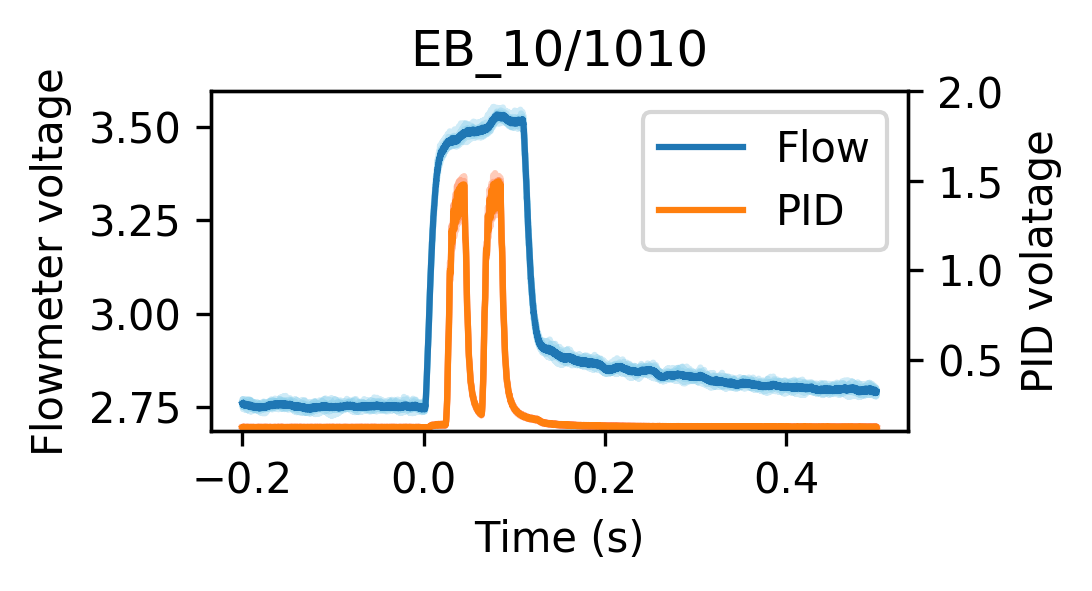

In [206]:
fig = plt.figure(figsize=(3, 1.5), dpi=300)

xs = np.arange(-.2, .5, 1/10000)
trial_num = 10
ax = fig.add_subplot(111)
for i in all_flows[trial_num]:
    plt.plot(xs, i, color='skyblue', alpha=0.4)
ax.plot(xs, np.mean(all_flows, axis=1)[trial_num], label='Flow')

ax.set_ylabel('Flowmeter voltage')
ax2 = ax.twinx()
ax2.plot([], label='Flow')
for i in all_trials_PID[trial_num]:
    ax2.plot(xs, i[3070:10070], alpha=0.4, color='coral')
ax2.plot(xs, mean_trial_PIDs[trial_num][3070:10070],  label='PID',color='C1')
ax2.set_ylim(.1, 2)
ax2.set_ylabel('PID volatage')
plt.legend()
ax.set_xlabel('Time (s)')
ax.set_title('EB_%d/%s' % (trial_num, str(bin(trial_num)[2:])))


In [207]:
def plot_pid_and_flow(trial_num, ax, legend=False):
    xs = np.arange(-.2, .5, 1/10000)
    for i in all_flows[trial_num]:
        ax.plot(xs, i, color='skyblue', alpha=0.4)
    ax.plot(xs, np.mean(all_flows, axis=1)[trial_num], label='Flow')
    #ax.set_ylabel('Flowmeter voltage')
    ax2 = ax.twinx()
    ax2.plot([], label='Flow')
    for i in all_trials_PID[trial_num]:
        ax2.plot(xs, i[3070:10070], alpha=0.4, color='coral')
    ax2.plot(xs, mean_trial_PIDs[trial_num][3070:10070],  label='PID',color='C1')
    ax2.set_ylim(.1, 2)
    #ax2.set_ylabel('PID volatage')
    if legend:
        plt.legend()
    #ax.set_xlabel('Time (s)')
    #ax.set_title('EB_%d/%s' % (trial_num, str(bin(trial_num)[2:])))
    return ax

In [208]:
def plot_onset_and_conc(mean_resp, onset_ax, conc_ax):
    xs = np.arange(-.5, .62, 1/100)[:-1]

    conc_ax.plot(xs, mean_resp[0], color='k', linestyle='--')
    conc_ax.plot(xs, mean_resp[conc_trials[-1]], color='lightgray')
    for index, i in enumerate(conc_trials[:-1]):
        conc_ax.plot(xs, mean_resp[i], color=matplotlib.cm.bwr((index+1)/len(conc_trials)/2))

    conc_ax.axvspan(0, 0.1, color='yellow', alpha=0.5)
    onset_ax.plot(xs, mean_resp[0], color='k', linestyle='--')
    for index2, i in enumerate(onset_trials[::-1]):
        onset_ax.plot(xs, mean_resp[i], color=matplotlib.cm.bwr(.5 + (index2)/len(plots_conc)/2))
    onset_ax.plot(xs, mean_resp[conc_trials[-1]], color='lightgray')
    onset_ax.axvspan(0, 0.1, color='yellow', alpha=0.5, zorder=-100)
    onset_ax.set_xticklabels([])

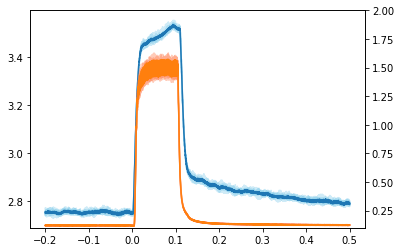

In [209]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax = plot_pid_and_flow(31, ax)

In [210]:
def plot_heatmap(ax, mean_usrt, select_trials, sorted_args=None, time_offset=25, cmap='binary', time_ticks_base = None, colorbar_ax=None):  
    if sorted_args is None:
        sorted_args = np.argsort(np.argmax(mean_usrt[:, select_trials[::-1][-1]], axis=-1))
    im = ax.imshow(mean_usrt[sorted_args][:, select_trials[::-1], time_offset:].reshape(145, -1), cmap=cmap, aspect='auto')
    ax.axvspan(50-time_offset, 50-time_offset+10, color='y', alpha=0.2)
    time_len = mean_usrt.shape[-1] - time_offset
    if time_ticks_base is None:
        pre_window = time_offset/100 - .5
        post_window = time_len/100 + pre_window
        
        time_ticks_base = np.arange(pre_window, post_window, -1*pre_window)
    
    full_xs = np.arange(time_offset/100-.5, time_len/100, 1/100).round(2)
    print(full_xs.round(2))
    xticks_base = np.array([np.where(full_xs == i)[0][0] for i in time_ticks_base])
    
 #   xticks_base = np.linspace(0, time_len, int(pre_window*-100))
    print(xticks_base)
    time_ticks = []
    xticks = []
    for i in range(len(select_trials)):
        xticks.append(xticks_base+i*time_len)
        time_ticks.append(time_ticks_base)

    ax.set_xticks(np.concatenate(xticks))
    
    ax.set_xticklabels(np.concatenate(time_ticks), rotation=90)
    for i in range(1, 10):
        ax.axvline(87*i, color='k')
        ax.axvspan(25+87*i, 35+87*i, color='y', alpha=0.2)
        ax.text(17+87*i, -2, glyphs[select_trials[::-1][i]])
    if colorbar_ax is None:
        divider = make_axes_locatable(ax)
        cax = divider.append_axes('right', size='5%', pad=0.05)
        plt.colorbar(mappable=im, cax=cax)
    else:
        plt.colorbar(mappable=im, cax=colorbar_ax)
    ax.text(17, -2, glyphs[select_trials[-1]])
    ax.set_xlabel('Time (ms)')
    ax.set_ylabel('Units')

In [211]:
def plot_psth(fig, gs, usrt, selected_trials, ui, xs, cmap='RdYlGn'):
    mean_usrt = [np.mean(i, axis=0) for i in usrt[ui]]
    std_usrt = [np.std(i, axis=0) for i in usrt[ui]]
    sub_gridspec = gs.subgridspec(ncols=1, nrows=2, hspace=.1)

    ax1 = fig.add_subplot(sub_gridspec[0])
    ax2 = fig.add_subplot(sub_gridspec[1])
    selected_trials = selected_trials[::-1]

    count = 0
    ax1.plot(xs, mean_usrt[0], color='k', linestyle='--')
    ax2.plot(xs, mean_usrt[0], color='k', linestyle='--')
    for index, i in enumerate(selected_trials[1:6]):
        ax1.plot(xs, mean_usrt[i], color=matplotlib.cm.get_cmap(cmap)(index/(len(selected_trials)-1)))
        count += 1
    count -= 1
    for index, i in enumerate(selected_trials[5:]):
        ax2.plot(xs, mean_usrt[i], color=matplotlib.cm.get_cmap(cmap)((index+count)/(len(selected_trials)-1)))
    
    ax1_lims = ax1.get_ylim()
    ax2_lims = ax2.get_ylim()
    ylim_max = np.max([ax1_lims, ax2_lims])
    ylim_min = np.min([ax1_lims, ax2_lims])
    ylim = [ylim_min, ylim_max]
    ax1.axvspan(0, 0.1, color='lightgray')
    ax2.axvspan(0, 0.1, color='lightgray')
    ax1.set_ylim(ylim)
    ax2.set_ylim(ylim)
    ax1.spines['top'].set_visible(False)
    ax1.spines['right'].set_visible(False)
    ax2.spines['top'].set_visible(False)
    ax2.spines['right'].set_visible(False)
    ax1.set_xticklabels([])


In [218]:
def dendo_and_heatmaps(fig, gs, link, z_scored, **kwargs):
    
    sub_gridspec = gs.subgridspec(1, 2, wspace=0.3)
    sub_sub_gridspec = sub_gridspec[0].subgridspec(1, 2, wspace=0.0)

    dend_ax = fig.add_subplot(sub_sub_gridspec[0])
    dend = dendrogram(link, ax=dend_ax, orientation='left', truncate_mode=None, no_labels=True)
    dend_ax.set_ylabel('Units')
    dend_ax.set_xlabel('Distance')
    dend_ax.set_xticks([])
    norm_heatmap_ax = fig.add_subplot(sub_sub_gridspec[1])
    resp_heatmap_ax = fig.add_subplot(sub_gridspec[1])
    vmax = np.max(np.abs(z_scored))
    im = norm_heatmap_ax.imshow(z_scored[dend['leaves'][::-1]], cmap='bwr', aspect='auto', vmax=vmax, vmin=-vmax)
#     plt.colorbar(mappable=im, ax=norm_heatmap_ax, aspect=40)
    norm_heatmap_ax.set_xticks(range(32))
    norm_heatmap_ax.set_xticklabels(glyphs, rotation=90, fontsize=5);
    norm_heatmap_ax.set_yticks([])
    divider = make_axes_locatable(norm_heatmap_ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    
    plt.colorbar(im, cax=cax)
#    heatmap_cbar_ax = fig.add_subplot(sub_gridspec[39])
    plot_heatmap(resp_heatmap_ax, mean_usrt1, select_trials, dend['leaves'][::-1], **kwargs)
 #   normed_cbar_ax = fig.add_subplot(sub_gridspec[37])
#    plt.colorbar(mappable=im, cax=normed_cbar_ax)

def plot_heatmap(ax, mean_usrt, select_trials, sorted_args=None, time_offset=25, cmap='binary', time_ticks_base = None, colorbar_ax=None):  
    if sorted_args is None:
        sorted_args = np.argsort(np.argmax(mean_usrt[:, select_trials[::-1][-1]], axis=-1))
    im = ax.imshow(mean_usrt[sorted_args][:, select_trials[::-1], time_offset:].reshape(145, -1), cmap=cmap, aspect='auto')
    ax.axvspan(50-time_offset, 50-time_offset+10, color='y', alpha=0.2)
    time_len = mean_usrt.shape[-1] - time_offset
    if time_ticks_base is None:
        pre_window = time_offset/100 - .5
        post_window = time_len/100 + pre_window
        
        time_ticks_base = np.arange(pre_window, post_window, -1*pre_window)
    
    full_xs = np.arange(time_offset/100-.5, time_len/100, 1/100).round(2)
    print(full_xs.round(2))
    xticks_base = np.array([np.where(full_xs == i)[0][0] for i in time_ticks_base])
    
 #   xticks_base = np.linspace(0, time_len, int(pre_window*-100))
    print(xticks_base)
    time_ticks = []
    xticks = []
    for i in range(len(select_trials)):
        xticks.append(xticks_base+i*time_len)
        time_ticks.append(time_ticks_base)

    ax.set_xticks(np.concatenate(xticks))
    
    ax.set_xticklabels(np.concatenate(time_ticks), rotation=90)
    for i in range(1, 10):
        ax.axvline(87*i, color='k')
        ax.axvspan(25+87*i, 35+87*i, color='y', alpha=0.2)
        ax.text(17+87*i, -2, glyphs[select_trials[::-1][i]], fontsize=7)
    if colorbar_ax is None:
        divider = make_axes_locatable(ax)
        cax = divider.append_axes('right', size='2.5%', pad=0.05)
        plt.colorbar(mappable=im, cax=cax)
    else:
        plt.colorbar(mappable=im, cax=colorbar_ax)
    ax.text(17, -2, glyphs[select_trials[-1]], fontsize=7)
    ax.set_xlabel('Time (ms)')
    ax.set_ylabel('Units')

[-0.25 -0.24 -0.23 -0.22 -0.21 -0.2  -0.19 -0.18 -0.17 -0.16 -0.15 -0.14
 -0.13 -0.12 -0.11 -0.1  -0.09 -0.08 -0.07 -0.06 -0.05 -0.04 -0.03 -0.02
 -0.01  0.    0.01  0.02  0.03  0.04  0.05  0.06  0.07  0.08  0.09  0.1
  0.11  0.12  0.13  0.14  0.15  0.16  0.17  0.18  0.19  0.2   0.21  0.22
  0.23  0.24  0.25  0.26  0.27  0.28  0.29  0.3   0.31  0.32  0.33  0.34
  0.35  0.36  0.37  0.38  0.39  0.4   0.41  0.42  0.43  0.44  0.45  0.46
  0.47  0.48  0.49  0.5   0.51  0.52  0.53  0.54  0.55  0.56  0.57  0.58
  0.59  0.6   0.61  0.62  0.63  0.64  0.65  0.66  0.67  0.68  0.69  0.7
  0.71  0.72  0.73  0.74  0.75  0.76  0.77  0.78  0.79  0.8   0.81  0.82
  0.83  0.84  0.85  0.86  0.87]
[ 0 25 50]


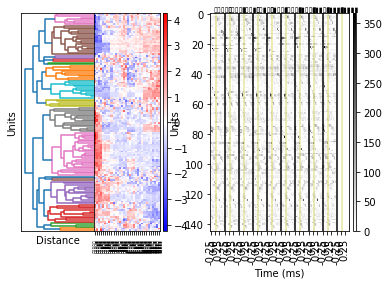

In [220]:
fig = plt.figure()
gs = matplotlib.gridspec.GridSpec(1, 1)[0]
dendo_and_heatmaps(fig, gs, link, z_scored, time_ticks_base=[-0.25, 0.0, 0.25])

[-0.25 -0.24 -0.23 -0.22 -0.21 -0.2  -0.19 -0.18 -0.17 -0.16 -0.15 -0.14
 -0.13 -0.12 -0.11 -0.1  -0.09 -0.08 -0.07 -0.06 -0.05 -0.04 -0.03 -0.02
 -0.01  0.    0.01  0.02  0.03  0.04  0.05  0.06  0.07  0.08  0.09  0.1
  0.11  0.12  0.13  0.14  0.15  0.16  0.17  0.18  0.19  0.2   0.21  0.22
  0.23  0.24  0.25  0.26  0.27  0.28  0.29  0.3   0.31  0.32  0.33  0.34
  0.35  0.36  0.37  0.38  0.39  0.4   0.41  0.42  0.43  0.44  0.45  0.46
  0.47  0.48  0.49  0.5   0.51  0.52  0.53  0.54  0.55  0.56  0.57  0.58
  0.59  0.6   0.61  0.62  0.63  0.64  0.65  0.66  0.67  0.68  0.69  0.7
  0.71  0.72  0.73  0.74  0.75  0.76  0.77  0.78  0.79  0.8   0.81  0.82
  0.83  0.84  0.85  0.86  0.87]
[ 0 25 50]


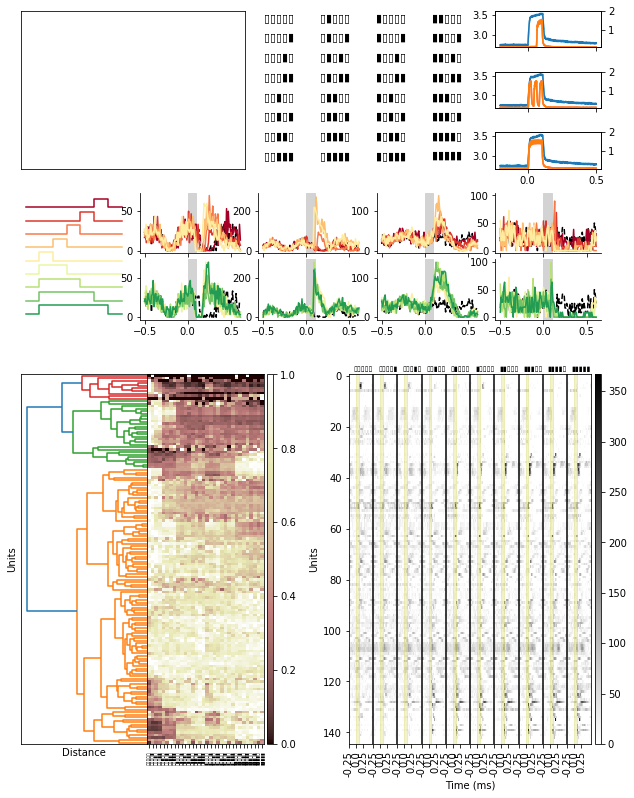

In [82]:
### Fig 1 plotting
fig = plt.figure(figsize=(8.3, 11.7))
gs = matplotlib.gridspec.GridSpec(25, 15,wspace=.5, hspace=4, left=0.0, right=0.97, bottom=0.1, top=0.97)

mouse_ax = fig.add_subplot(gs[:6, :6])
mouse_ax.set_xticks([])
mouse_ax.set_yticks([])
blip_ax = fig.add_subplot(gs[:6, 6:12])
for i in range(32):
    blip_ax.text(int(i/8)+0.1, 8-i%8-0.5, glyphs[i], fontsize=11)
blip_ax.set_xlim(0, 4)
blip_ax.set_ylim(0, 8)
blip_ax.axis('off')

odour_ax1 = fig.add_subplot(gs[:2, 12:15])
odour_ax2 = fig.add_subplot(gs[2:4, 12:15], sharex=odour_ax1, sharey=odour_ax1)
odour_ax3 = fig.add_subplot(gs[4:6, 12:15], sharex=odour_ax1, sharey=odour_ax1)
plt.setp(odour_ax1.get_xticklabels(), visible=False)
plt.setp(odour_ax2.get_xticklabels(), visible=False)
odour_ax1 = plot_pid_and_flow(3, odour_ax1)
odour_ax2 = plot_pid_and_flow(21, odour_ax2)
odour_ax3 = plot_pid_and_flow(31, odour_ax3)


xs = np.arange(-.5, .62, 1/100)[:-1]
stimuli_ax = fig.add_subplot(gs[6:11, :3])

for index, i in enumerate(plots_all[:-1][::-1]):
    stimuli_ax.step(range(len(i)), i-index*1.5, color=matplotlib.cm.RdYlGn(index/(len(plots_all)-1)))
    
stimuli_ax.axis('off')
#plot_psth(fig, gs[20:25, :3], units_usrt1, select_trials, 42, xs)
plot_psth(fig, gs[6:11, 3:6], units_usrt1, select_trials, sorted_args[-38], xs)
plot_psth(fig, gs[6:11, 6:9], units_usrt1, select_trials, 42, xs)
plot_psth(fig, gs[6:11, 9:12], units_usrt1, select_trials, sorted_args[99], xs)
plot_psth(fig, gs[6:11, 12:15], units_usrt1, select_trials, sorted_args[5], xs)

dendo_and_heatmaps(fig, gs[12:25, :], link, summed_response1, time_ticks_base=[-0.25, 0.0, 0.25])


In [44]:
#In response plot include example cell PSTH
# In response plot possibly sort by Hierarchical clustering
# In resposne plot change the colour of the odour band
# In rp fix the x tics
# in rp decrease colourbar size


In [139]:
print(np.argsort(np.argmax(mean_usrt1[sorted_args1, :, 50:100].sum(axis=-1), axis=-1)))

[ 81  83  23  24 116  26  27  28  21  84 114  87 107  91 104  92  99 115
  95  41  18 139 137   3  69  63 143 135  19  61  57  12  75 128  76  77
  60  73  49  79  93  33  67   4   6 131  11 117  13 127  96 103 136   8
  58  16  20  29  86  65  90   0 111  85 132 106 126  72  40  14 140   2
 113 109 142  78  32  10 101  31 125   1   5  35  22  50  55  71   7 130
 100  62  17 110 112 129  97 121   9 120  36 119  48  52  45  38  66 134
  56  82  98 122  15 144 105  68  70  59 102  94  89 138  74  80  46 108
  88 123  43  34  47  30  25  54  64 141 118  44  39 133  51 124  42  37
  53]


[-0.25 -0.24 -0.23 -0.22 -0.21 -0.2  -0.19 -0.18 -0.17 -0.16 -0.15 -0.14
 -0.13 -0.12 -0.11 -0.1  -0.09 -0.08 -0.07 -0.06 -0.05 -0.04 -0.03 -0.02
 -0.01  0.    0.01  0.02  0.03  0.04  0.05  0.06  0.07  0.08  0.09  0.1
  0.11  0.12  0.13  0.14  0.15  0.16  0.17  0.18  0.19  0.2   0.21  0.22
  0.23  0.24  0.25  0.26  0.27  0.28  0.29  0.3   0.31  0.32  0.33  0.34
  0.35  0.36  0.37  0.38  0.39  0.4   0.41  0.42  0.43  0.44  0.45  0.46
  0.47  0.48  0.49  0.5   0.51  0.52  0.53  0.54  0.55  0.56  0.57  0.58
  0.59  0.6   0.61  0.62  0.63  0.64  0.65  0.66  0.67  0.68  0.69  0.7
  0.71  0.72  0.73  0.74  0.75  0.76  0.77  0.78  0.79  0.8   0.81  0.82
  0.83  0.84  0.85  0.86  0.87]
[ 0 25 50 75]


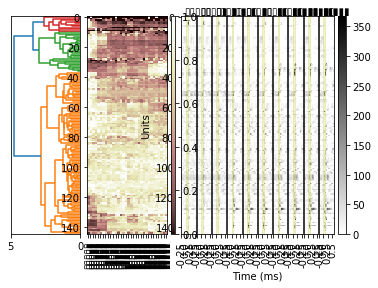

In [101]:
fig = plt.figure()
gs = matplotlib.gridspec.GridSpec(1, 1)
dendo_and_heatmaps(fig, gs[0], link, summed_response1)